In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
import kr_helper_funcs as kr
from sklearn.preprocessing import MinMaxScaler
import kr_helper_funcs as kr
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from lime import lime_tabular
import shap
import tensorflow_addons as tfa
import os
from tensorflow.keras.utils import to_categorical
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# New Model - this is trained using only continous values and the zip_code (the bias) is removed

In [2]:
name = 'mouse'
fileName = "{}/{}-values.csv".format(name, name)

radam = tfa.optimizers.RectifiedAdam()
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
model = tf.keras.models.load_model('{}/{}.h5'.format(name, name), custom_objects={"f1": kr.f1, "optimizer": ranger})
X_train_unscaled = np.load("{}/X_train_unscaled.npy".format(name))
X_test_unscaled = np.load("{}/X_test_unscaled.npy".format(name))
y_train = np.load("{}/y_test.npy".format(name))
y_test = np.load("{}/y_test.npy".format(name))
df = pd.read_csv('{}/{}-df.csv'.format(name,name))
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

prev_scaled_row = None
cached_map_values = None
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train_unscaled)
# X_test = scaler.transform(X_test_unscaled)

res = pd.read_csv(fileName)

save_path = os.path.join('C:/Users/dan39/OneDrive/Desktop/DissertationLatex/DissertationLatex/images/', name)
                         
def save(img_name):
    plt.savefig(os.path.join(save_path, img_name))

In [3]:
## Data 
# original_probability - the probability of the row before any column is changed
# new_probability - the new probability after features in the row have been replaced depending on the neutralizing strategy
# confidence_diff - difference (original_probability -new_probability) 
# original_class - the class predicted by the model using the original row
# class_change - if the new row is labelled as a different class
# no_features - represents the number of features changed inside the row (from 0 to 10 incl)
# nsamples - the number of samples the explainer can use to generate an explanation (here we only use auto)
# explainer - which explainer has been used? shap, lime, eli5, or random?
# time - time taken for the explainer
# feature_rankings - in a list with many rankings we can replace the first ones (most important), middle, or last ones (lest important)
# strategy - mean:neutralize the points using the mean average of the training set; 
#            distribution - use 20 randomly selected values equally from both classes to replace this feature, then generate a prediction for each and average the prediction
#            distribution_others: neuttralise all other features except the points that are important
#i columns represnet the feaure that has been neutralised 

In [4]:
pd.options.display.max_columns = None
res

,original_probability,new_probability,confidence_diff,original_class,class_change,no_features,nsamples,explainer,time,feature_rankings,strategy,i0,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10
0,1.138276e-01,0.113828,0.000000e+00,4,False,0,auto,shap,47.973642,first,mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.138276e-01,0.113828,-1.788139e-07,4,False,0,auto,shap,4.409572,first,distribution,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.138276e-01,0.098506,7.418739e-01,4,True,0,auto,shap,4.135486,first,distribution_others,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.138276e-01,0.113828,0.000000e+00,4,False,0,auto,shap,0.393944,middle,mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.138276e-01,0.113828,-1.788139e-07,4,False,0,auto,shap,6.394189,middle,distribution,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43159,9.276787e-07,0.000007,3.832877e-03,2,False,10,auto,random,1.854744,middle,distribution,67.0,8.0,35.0,37.0,28.0,57.0,46.0,3.0,25.0,44.0,NaN
43160,9.276787e-07,0.142831,8.001725e-01,2,False,10,auto,random,1.975999,middle,distribution_others,67.0,8.0,35.0,37.0,28.0,57.0,46.0,3.0,25.0,44.0,NaN
43161,9.276787e-07,0.000004,7.809997e-04,2,False,10,auto,random,0.168899,last,mean,62.0,58.0,9.0,24.0,52.0,15.0,12.0,20.0,66.0,69.0,NaN
43162,9.276787e-07,0.000015,1.569986e-03,2,False,10,auto,random,1.861178,last,distribution,62.0,58.0,9.0,24.0,52.0,15.0,12.0,20.0,66.0,69.0,NaN


In [5]:
font = {
#     'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
plt.rc('font', **font)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels


In [6]:
df.columns

Index(['ITSN1_N', 'BDNF_N', 'NR1_N', 'NR2A_N', 'pAKT_N', 'pBRAF_N',
       'pCAMKII_N', 'pCREB_N', 'pELK_N', 'pERK_N', 'pJNK_N', 'PKCA_N',
       'pMEK_N', 'pNR1_N', 'pNR2A_N', 'pNR2B_N', 'pPKCAB_N', 'pRSK_N', 'AKT_N',
       'BRAF_N', 'CAMKII_N', 'CREB_N', 'ELK_N', 'ERK_N', 'GSK3B_N', 'JNK_N',
       'MEK_N', 'TRKA_N', 'RSK_N', 'APP_N', 'Bcatenin_N', 'SOD1_N', 'MTOR_N',
       'P38_N', 'pMTOR_N', 'DSCR1_N', 'AMPKA_N', 'NR2B_N', 'pNUMB_N',
       'RAPTOR_N', 'TIAM1_N', 'pP70S6_N', 'NUMB_N', 'P70S6_N', 'pGSK3B_N',
       'pPKCG_N', 'CDK5_N', 'S6_N', 'ADARB1_N', 'AcetylH3K9_N', 'RRP1_N',
       'BAX_N', 'ARC_N', 'ERBB4_N', 'nNOS_N', 'Tau_N', 'GFAP_N', 'GluR3_N',
       'GluR4_N', 'IL1B_N', 'P3525_N', 'pCASP9_N', 'PSD95_N', 'SNCA_N',
       'Ubiquitin_N', 'pGSK3B_Tyr216_N', 'SHH_N', 'pS6_N', 'SYP_N', 'CaNA_N',
       'class'],
      dtype='object')

In [7]:
df.corr()["class"].sort_values(ascending=False)

class           1.000000
Tau_N           0.577031
APP_N           0.428661
AcetylH3K9_N    0.363102
Ubiquitin_N     0.362567
                  ...   
pNR1_N         -0.137455
pPKCAB_N       -0.139453
CaNA_N         -0.148412
pERK_N         -0.162891
GluR3_N        -0.403741
Name: class, Length: 71, dtype: float64

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
[2.0901074409484863, 2.0667891502380367, 2.0621769428253174, 2.031752347946167, 2.021130084991455, 1.9926292896270752, 1.9911257028579712, 1.9116184711456297, 1.8918551206588743, 1.8354448080062864, 1.825267314910889, 1.8052361011505127, 1.7365522384643557, 1.6785709857940674, 1.6858901977539062, 1.6023026704788208, 1.550890564918518, 1.5742522478103638, 1.5037301778793335, 1.4643025398254397, 1.4096012115478516, 1.3744654655456543, 1.3029499053955078, 1.2227050065994265, 1.1870943307876587, 1.2290279865264893, 1.1228066682815552, 1.1618850231170654, 1.1086843013763428, 1.0223418474197388, 0.9717235565185548, 0.976090133190155, 0.9478703141212464, 0.9017130732536316, 0.8408797979354858, 0.8326902389526367, 0.7963505983

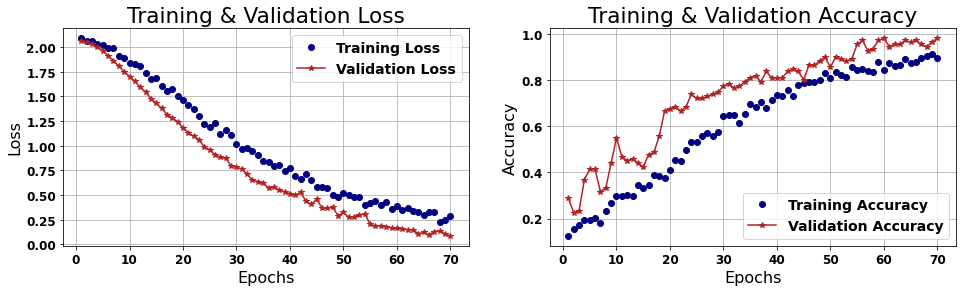

In [8]:
history = pd.read_csv('{}/mouse-history.csv'.format(name, name))
history_dict = history.to_dict('list')
ax = kr.show_plots(history_dict, path = os.path.join(save_path, "model_history"))
# save("history")

In [9]:
# help(plt.savefig)

In [10]:
def save_report_to_latex(report):
    df_latex = pd.DataFrame(report).transpose()    
    with open( os.path.join(save_path, "classification_report") + '.tex','w') as tf:
        tf.write(df_latex.to_latex())
    return

predictions = model.predict_classes(X_test)
# save_report_to_latex(classification_report(y_test, predictions, digits=2, output_dict=True))
print(classification_report(y_test, predictions))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        14
           4       0.91      1.00      0.95        21
           5       1.00      0.83      0.91        12
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00        14

    accuracy                           0.98       111
   macro avg       0.99      0.98      0.98       111
weighted avg       0.98      0.98      0.98       111



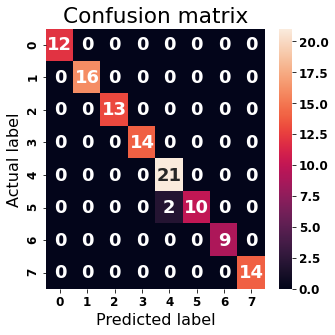

In [11]:
kr.plot_cm_categorical(y_test, predictions, ["0", "1","2", "3","4", "5","6", "7"])
save("confusion_matrix")

In [12]:
# plt.figure(figsize=(75,75))
# sns.heatmap(df.corr(),annot=True,cmap='viridis', linewidth=1)
# plt.ylim(20, 0)


In [13]:
def plot_roc(name, labels, predictions, ax, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    lw = 2
    plt.plot(fp, tp, color='darkorange',
             lw=lw, label='ROC curve '+ name, **kwargs)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    
def plot_model_results(model):
    fig, (f1, f2, f3, f4) =plt.subplots(1,4, figsize=(25,6))
    predictions = model.predict_classes(X_test)
    report = classification_report(y_test,predictions)
    print(report)
    report_json = classification_report(y_test,predictions, output_dict=True)
#     save_report_to_latex(model_name, report_json)
    
    
    losses = pd.DataFrame(history)
    fig1 = losses[['loss','val_loss']].plot(ax=f1) 
    fig1.set_ylabel('Cost')
    fig1.set_xlabel('Epochs')
    
    cm = confusion_matrix(y_test,predictions > 0.5)
    fig2= sns.heatmap(cm, annot=True, fmt="d", ax=f2)
    fig2.set_title('Confusion matrix @{:.2f}'.format(0.5))
    fig2.set_ylabel('Actual label')
    fig2.set_xlabel('Predicted label')
    fig2.set_ylim(2, 0)

    fig3 = plot_roc("Train Baseline",y_train, model.predict_classes(X_train[:len(X_test)]) , ax=f4)
    fig3 = plot_roc("Test Baseline", y_test, model.predict_classes(X_test), ax=f4, linestyle='--')
    
    fig4 = losses[['accuracy','val_accuracy']].plot(ax=f3) 
    fig4.set_ylabel('Accuracy')
    fig4.set_xlabel('Epochs')
#     save('/building_ann/' + model_name + '.png')
    plt.show()
# plot_model_results(model)

In [14]:
len(X_test)

111

In [15]:
res[(res['nsamples'] == 'auto') & (res['explainer'] == 'random')].head()


,original_probability,new_probability,confidence_diff,original_class,class_change,no_features,nsamples,explainer,time,feature_rankings,strategy,i0,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10
32373,0.113828,0.113828,0.000000e+00,4,False,0,auto,random,0.165300,first,mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32374,0.113828,0.113828,-1.788139e-07,4,False,0,auto,random,1.512080,first,distribution,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32375,0.113828,0.120671,7.623365e-01,4,True,0,auto,random,1.591442,first,distribution_others,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32376,0.113828,0.113828,0.000000e+00,4,False,0,auto,random,0.144382,middle,mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32377,0.113828,0.113828,-1.788139e-07,4,False,0,auto,random,1.517021,middle,distribution,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## G1 Number of rows from each class (50 for class 0 and 50 for class 1)

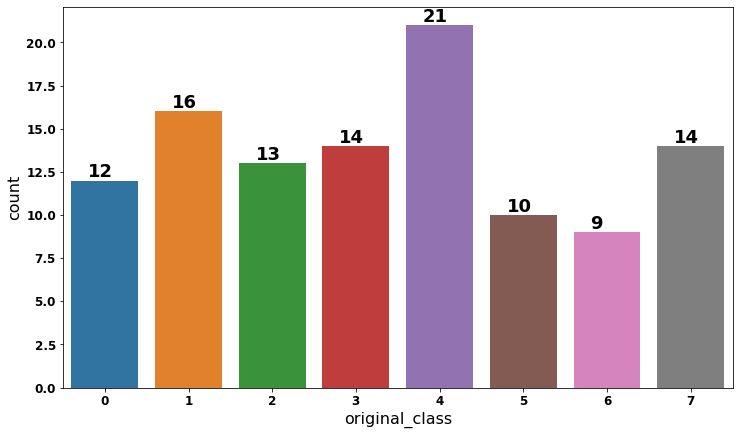

In [16]:
plt.figure(figsize=(12,7))
f = sns.countplot(x="original_class",data=res[(res['nsamples'] == 'auto') & (res['strategy'] == 'distribution') & (res['explainer'] == 'eli5') 
                                          & (res['explainer'] == 'eli5') & (res['feature_rankings'] == 'first')  & (res['no_features'] == 0)])
# plt.title("Number of rows predicted as the same class vs predicted as opposite class after columns have been neutralized based on the explainer's identified features")
for p in f.patches:
#     ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.0, p.get_height()+0.2))
    f.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+0.2))
save("class_distribution")

## G2 All class changes (per class) across all explainers that occured while using strategy distribution and feature ranking first

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


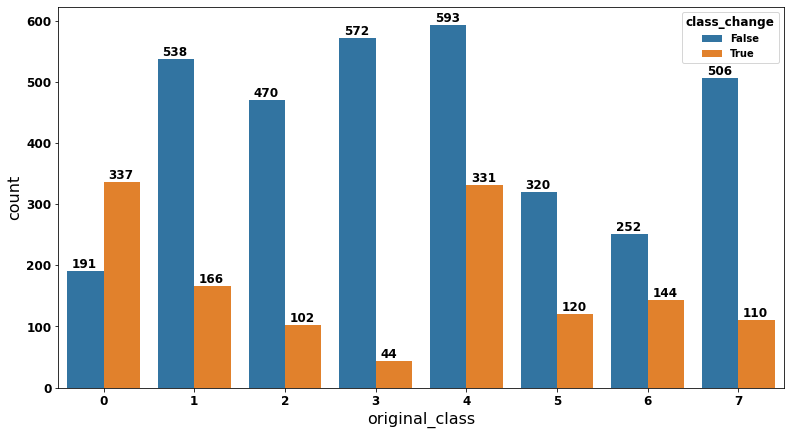

In [17]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)
plt.rc('legend', fontsize=10)
plt.figure(figsize=(13,7))
ax = sns.countplot(x="original_class",data=res[(res['nsamples'] == 'auto') & (res['strategy'] == 'distribution') & (res['feature_rankings'] == 'first') ], hue = 'class_change')
# plt.legend(loc = 'lower left')
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.05, p.get_height()+5))

save("class_distribution_changes_distribution_first")
# plt.title("Number of rows predicted as the same class vs predicted as opposite class after columns have been neutralized based on the explainer's identified features")

## G3 All class changes (per explainer) across both classes that occured while using strategy distribution and feature ranking first

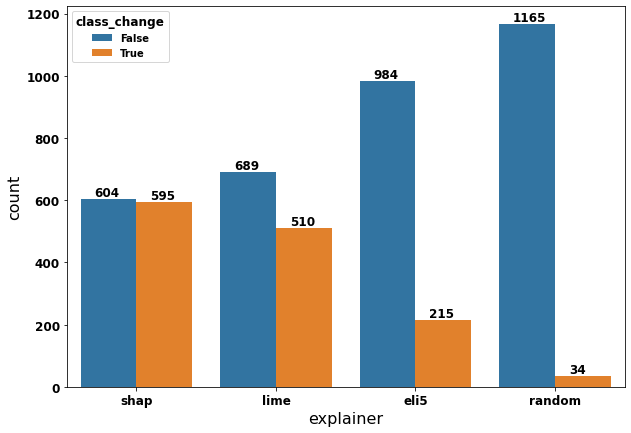

In [18]:
plt.figure(figsize=(10,7))
ax =sns.countplot(x="explainer",data=res[(res['nsamples'] == 'auto') & (res['strategy'] == 'distribution') & (res['feature_rankings'] == 'first')], hue = 'class_change')
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+10))
# plt.title("Number of rows predicted as the same class vs predicted as opposite class after columns have been neutralized based on the explainer's identified features")
save("explainer_distribution_changes_all")

In [19]:
len(res[(res['nsamples'] == 'auto') & (res['strategy'] == 'distribution') ])

14388

In [20]:
res.count()

original_probability    43164
new_probability         43164
confidence_diff         43164
original_class          43164
class_change            43164
no_features             43164
nsamples                43164
explainer               43164
time                    43164
feature_rankings        43164
strategy                43164
i0                      37980
i1                      34182
i2                      30384
i3                      26586
i4                      22788
i5                      18990
i6                      15192
i7                      11394
i8                       7596
i9                       3798
i10                         0
dtype: int64

In [21]:
df.columns

Index(['ITSN1_N', 'BDNF_N', 'NR1_N', 'NR2A_N', 'pAKT_N', 'pBRAF_N',
       'pCAMKII_N', 'pCREB_N', 'pELK_N', 'pERK_N', 'pJNK_N', 'PKCA_N',
       'pMEK_N', 'pNR1_N', 'pNR2A_N', 'pNR2B_N', 'pPKCAB_N', 'pRSK_N', 'AKT_N',
       'BRAF_N', 'CAMKII_N', 'CREB_N', 'ELK_N', 'ERK_N', 'GSK3B_N', 'JNK_N',
       'MEK_N', 'TRKA_N', 'RSK_N', 'APP_N', 'Bcatenin_N', 'SOD1_N', 'MTOR_N',
       'P38_N', 'pMTOR_N', 'DSCR1_N', 'AMPKA_N', 'NR2B_N', 'pNUMB_N',
       'RAPTOR_N', 'TIAM1_N', 'pP70S6_N', 'NUMB_N', 'P70S6_N', 'pGSK3B_N',
       'pPKCG_N', 'CDK5_N', 'S6_N', 'ADARB1_N', 'AcetylH3K9_N', 'RRP1_N',
       'BAX_N', 'ARC_N', 'ERBB4_N', 'nNOS_N', 'Tau_N', 'GFAP_N', 'GluR3_N',
       'GluR4_N', 'IL1B_N', 'P3525_N', 'pCASP9_N', 'PSD95_N', 'SNCA_N',
       'Ubiquitin_N', 'pGSK3B_Tyr216_N', 'SHH_N', 'pS6_N', 'SYP_N', 'CaNA_N',
       'class'],
      dtype='object')

## G4 This shows a total count for each explainer of features that appear in the i coulumns regradless of their position (importance). For eli5 the count is always the same as it always returns the same features independent of the row (this is a global feature importance). The  (res["original_class"] == 0) can be commented out for a count specific to a class

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


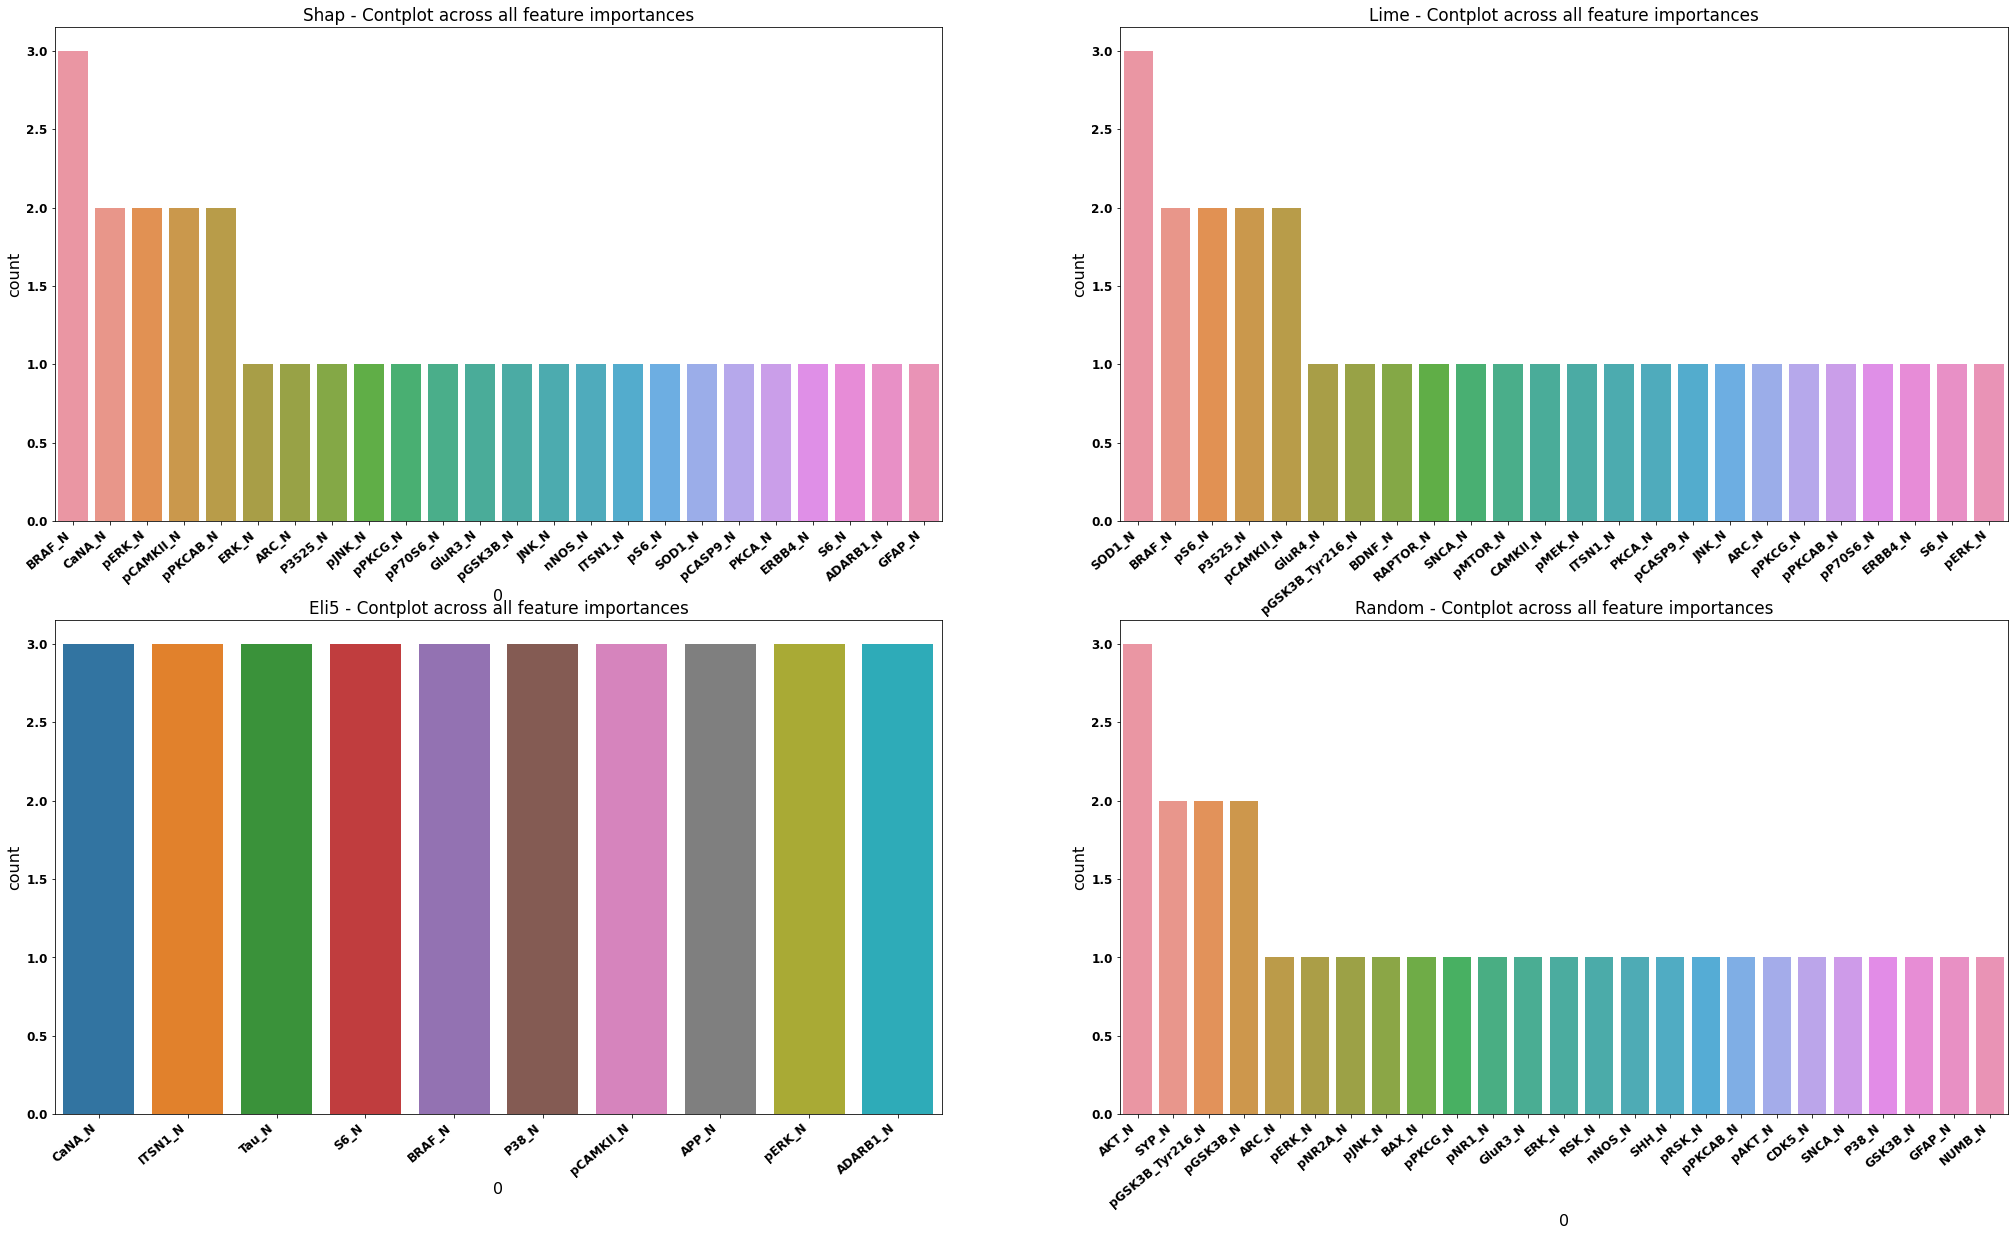

<Figure size 1440x288 with 0 Axes>

In [22]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('legend', fontsize=10)

def get_countplot(explainer, feature_rankings="first"):
    columns = df.drop('class', axis=1).columns
    result = res[(res['nsamples'] == 'auto') & (res['explainer'] == explainer) & (res["feature_rankings"] == feature_rankings) & 
#                  (res["original_class"] == 1) & 
                 (res['strategy'] == 'distribution') & (res["no_features"]==10)].drop(['original_probability',"new_probability", "confidence_diff", "original_class", "class_change","no_features","nsamples","explainer","time","feature_rankings", "strategy"],axis=1)
    result.columns = [''] * len(result.columns)
    flat_list = pd.DataFrame([columns[int(item)] for sublist in result.values.tolist() for item in sublist if not pd.isnull(item)])
    return flat_list[:30]

f, ax = plt.subplots(nrows=2, ncols=2, figsize=(35, 20))
plt.figure(figsize=(20,4))

countplot_list = get_countplot("shap", "first")
# print(countplot_list)
ax[0][0] = sns.countplot(x =0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[0][0])
ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=40, ha="right")
ax[0][0].set_title("Shap - Contplot across all feature importances")

countplot_list = get_countplot("lime")
ax[0][1] = sns.countplot(x =0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[0][1])
ax[0][1].set_xticklabels(ax[0][1].get_xticklabels(), rotation=40, ha="right")
ax[0][1].set_title("Lime - Contplot across all feature importances")

countplot_list = get_countplot("eli5")
ax[1][0] = sns.countplot(x =0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[1][0])
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), rotation=40, ha="right")
ax[1][0].set_title("Eli5 - Contplot across all feature importances")

countplot_list = get_countplot("random")
ax[1][1] = sns.countplot(x = 0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[1][1])
ax[1][1].set_xticklabels(ax[1][1].get_xticklabels(), rotation=40, ha="right")
ax[1][1].set_title("Random - Contplot across all feature importances")
save("countplot_feature_importances")
f.savefig(os.path.join(save_path, "countplot_feature_importances"))

In [23]:
countplot_list = get_countplot("random")
countplot_list

,0
0,NUMB_N
1,SHH_N
2,pNR2A_N
3,AKT_N
4,ERK_N
5,SYP_N
6,pGSK3B_Tyr216_N
7,CDK5_N
8,pPKCG_N
9,nNOS_N


## G5 Correlation on original dataset

In [24]:
df.head()

,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,pNUMB_N,RAPTOR_N,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,pS6_N,SYP_N,CaNA_N,class
0,0.828696,0.405862,2.921435,5.167979,0.207174,0.176640,3.728084,0.239283,1.666579,0.969466,0.321260,0.406562,0.255293,1.056343,1.099300,1.925284,2.231671,0.426859,0.873228,0.512773,0.343220,0.167629,1.852756,3.366492,1.503675,0.246019,0.305424,0.851006,0.165179,0.441557,2.578215,0.340857,0.487664,0.401050,0.781365,0.534033,0.431846,0.618023,0.361417,0.321960,0.427297,0.252056,0.242086,1.061181,0.163758,1.862368,0.321175,0.541041,2.159547,0.134639,0.158178,0.196124,0.132001,0.161120,0.210988,0.210379,0.128145,0.292461,0.152597,0.527242,0.348062,1.687551,2.436587,0.168172,1.139154,0.987774,0.239752,0.132001,0.486912,1.627181,0
1,0.841974,0.388584,2.862575,5.194163,0.223433,0.167725,3.648240,0.221030,1.565150,0.991845,0.342918,0.396910,0.270815,1.032790,1.078712,1.893047,2.330987,0.409185,0.789013,0.511502,0.344807,0.166695,1.852532,3.431159,1.471674,0.242060,0.300172,0.833648,0.162661,0.437253,2.538026,0.337682,0.472618,0.402318,0.786524,0.533219,0.429871,0.603176,0.360258,0.296052,0.425837,0.252017,0.242120,1.063985,0.169981,1.692204,0.320473,0.539226,2.167098,0.136273,0.161579,0.193348,0.139008,0.161529,0.210798,0.193398,0.134583,0.291489,0.151884,0.519787,0.365119,1.662872,2.354728,0.174704,1.227851,0.981655,0.249031,0.139008,0.467833,1.562096,0
2,0.852882,0.400561,2.968155,5.350820,0.208790,0.173261,3.814545,0.222300,1.741732,0.989999,0.328976,0.397930,0.263795,1.092289,1.094043,1.915958,1.952540,0.454075,0.793754,0.533205,0.352048,0.172559,1.965786,3.434249,1.541802,0.251952,0.345908,0.881393,0.165278,0.443460,2.609615,0.342398,0.493903,0.410913,0.812791,0.564699,0.441179,0.640232,0.374331,0.299675,0.445214,0.252303,0.241042,1.059453,0.175230,1.654840,0.317856,0.561875,2.182447,0.135914,0.167508,0.192238,0.134804,0.181034,0.202534,0.204300,0.129555,0.270062,0.153629,0.506309,0.349753,1.716362,2.437317,0.156001,1.226103,0.994146,0.247956,0.134804,0.462501,1.571868,0
3,0.755390,0.348346,2.624901,4.727509,0.205892,0.161192,3.778530,0.194153,1.505475,0.819167,0.311548,0.385822,0.241562,0.948414,0.924822,1.755842,2.297212,0.484818,0.742183,0.459194,0.337510,0.161982,1.364714,2.814990,1.440795,0.234902,0.274975,0.766452,0.150581,0.407608,2.311999,0.312112,0.466305,0.394740,0.740603,0.522971,0.391918,0.585055,0.345186,0.286714,0.399932,0.277458,0.208718,0.969007,0.153779,2.027937,0.299825,0.466762,1.795148,0.126091,0.144363,0.176977,0.118982,0.163632,0.195311,0.194126,0.119356,0.276939,0.134635,0.526503,0.316600,1.586368,2.382140,0.145049,1.056498,0.970067,0.233225,0.118982,0.479110,1.646608,0
4,0.757917,0.350051,2.634509,4.735602,0.210526,0.165671,3.871971,0.194297,1.531613,0.815057,0.315001,0.391525,0.254142,0.955370,0.938465,1.744844,2.477854,0.476502,0.715880,0.486307,0.338668,0.160600,1.398174,2.891018,1.469402,0.234870,0.270033,0.755438,0.149555,0.411360,2.320861,0.309478,0.472332,0.393666,0.739209,0.542207,0.389947,0.587400,0.346557,0.290319,0.405838,0.354671,0.212714,0.972906,0.163062,1.969799,0.303008,0.491797,1.763485,0.124348,0.153741,0.188106,0.128635,0.167972,0.196992,0.197117,0.128635,0.283371,0.137211,0.542568,0.340355,1.619190,2.386217,0.150945,1.132737,0.980798,0.244469,0.128635,0.438354,1.607631,0


In [25]:
# Correlation on original dataset
df.corr()["class"]

ITSN1_N    0.142265
BDNF_N     0.043714
NR1_N     -0.091457
NR2A_N    -0.106153
pAKT_N     0.309994
             ...   
SHH_N      0.194951
pS6_N      0.191073
SYP_N      0.010522
CaNA_N    -0.148412
class      1.000000
Name: class, Length: 71, dtype: float64

## G6 Distribution of class changes based on explainer and number of features eliminated. The graphs look fine for class 1 but the model is biased for class 0. ((res["original_class"] == 0)) and res['strategy'] == 'distribution_others') are interesting to change

Text(0.5, 1.0, 'Random')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


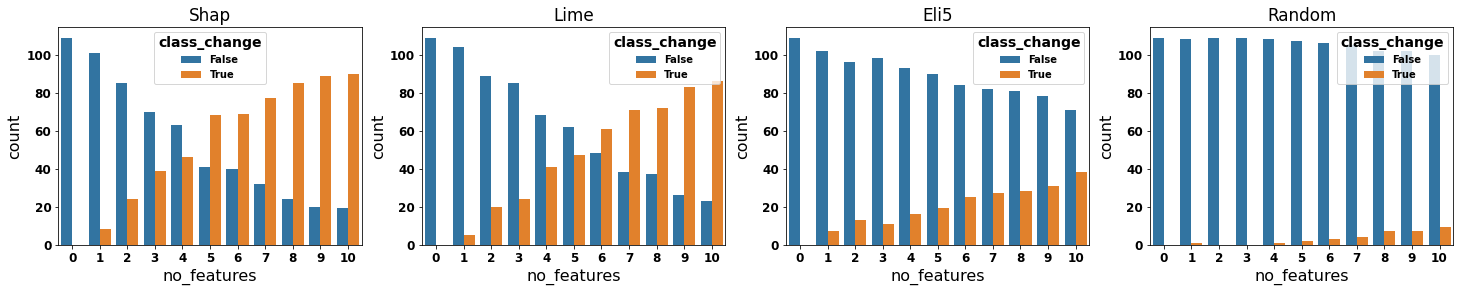

In [26]:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(25, 4))

data = res[(res['nsamples'] == 'auto') &  (res["feature_rankings"] == "first") 
#                & (res["original_class"] == 1)
               & (res['strategy'] == 'distribution')]

ax[0]=sns.countplot(x="no_features",data=data[data['explainer'] == 'shap'], hue = 'class_change', ax = ax[0])
ax[0].set_title("Shap")

ax[1]=sns.countplot(x="no_features",data=data[data['explainer'] == 'lime'], hue = 'class_change', ax = ax[1])
ax[1].set_title("Lime")

ax[2]=sns.countplot(x="no_features",data=data[data['explainer'] == 'eli5'], hue = 'class_change', ax = ax[2])
ax[2].set_title("Eli5")

ax[3]=sns.countplot(x="no_features",data=data[data['explainer'] == 'random'], hue = 'class_change', ax = ax[3])
ax[3].set_title("Random")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


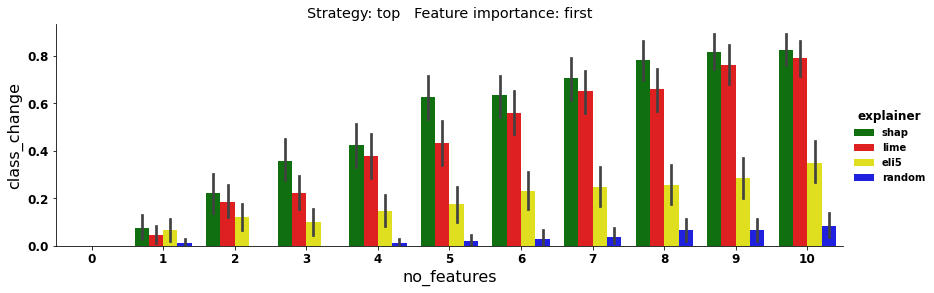

In [27]:
font = {
#     'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)

palette = {"shap":"green", "lime":"red", "eli5":"yellow", "random":"blue"}
data = res[ (res['nsamples'] == 'auto') & (res['strategy'] == 'distribution') & (res["feature_rankings"] == "first") ]
f = sns.catplot(x="no_features", y="class_change", hue="explainer", kind="bar", data=data, height=4, aspect=3,  palette = palette);
# plt.title("Proportion of class changes per number of features neutralised for all classes - strategy: top feature importance: first")
plt.title("Strategy: top   Feature importance: first")
f.savefig(os.path.join(save_path, "catplot_no_features_per_explainer_distribution_all_classes_first"))

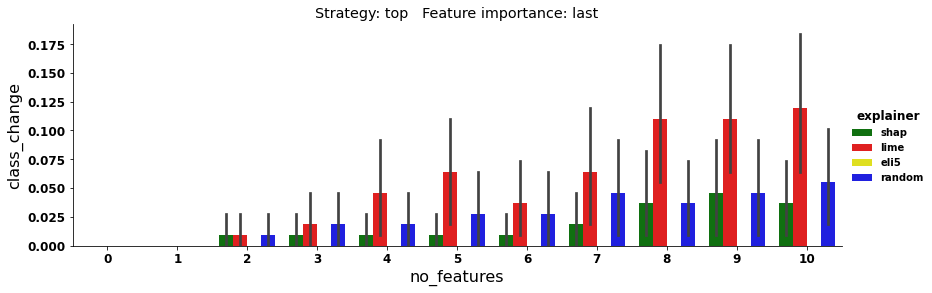

In [28]:
data = res[ (res['nsamples'] == 'auto') & (res['strategy'] == 'distribution') & (res["feature_rankings"] == "last") ]
f = sns.catplot(x="no_features", y="class_change", hue="explainer", kind="bar", data=data, height=4, aspect=3,  palette = palette);
# plt.title("Proportion of class changes per number of features neutralised for all classes - strategy: top feature importance: first")
plt.title("Strategy: top   Feature importance: last")
f.savefig(os.path.join(save_path, "catplot_no_features_per_explainer_distribution_all_classes_last"))

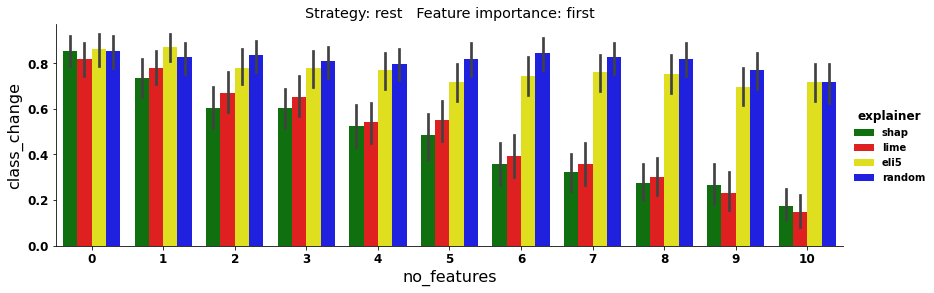

In [29]:
data = res[ (res['nsamples'] == 'auto') & (res['strategy'] == 'distribution_others') & (res["feature_rankings"] == "first") ]
f = sns.catplot(x="no_features", y="class_change", hue="explainer", kind="bar", data=data, height=4, aspect=3,  palette = palette);
# plt.title("Proportion of class changes per number of features neutralised for all classes - strategy: top feature importance: first")
plt.title("Strategy: rest   Feature importance: first")
f.savefig(os.path.join(save_path, "catplot_no_features_per_explainer_distribution_others_all_classes_first"))

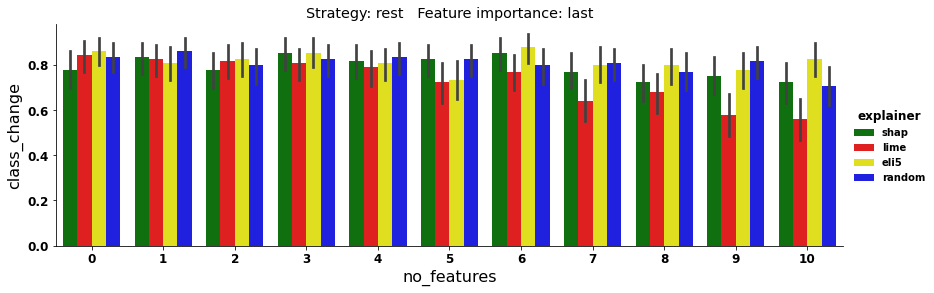

In [30]:
data = res[(res['nsamples'] == 'auto') & (res['strategy'] == 'distribution_others') & (res["feature_rankings"] == "last") ]
f = sns.catplot(x="no_features", y="class_change", hue="explainer", kind="bar", data=data, height=4, aspect=3,  palette = palette);
# plt.title("Proportion of class changes per number of features neutralised for all classes - strategy: top feature importance: first")
plt.title("Strategy: rest   Feature importance: last")
f.savefig(os.path.join(save_path, "catplot_no_features_per_explainer_distribution_others_all_classes_last"))

## G7 Average of confidence level change vs number of features neutralized. If no feature is altered the (old prediction - new prediction) == 0 should stay the same. The more features we change, the higher should the difference increase. This average is on both classes

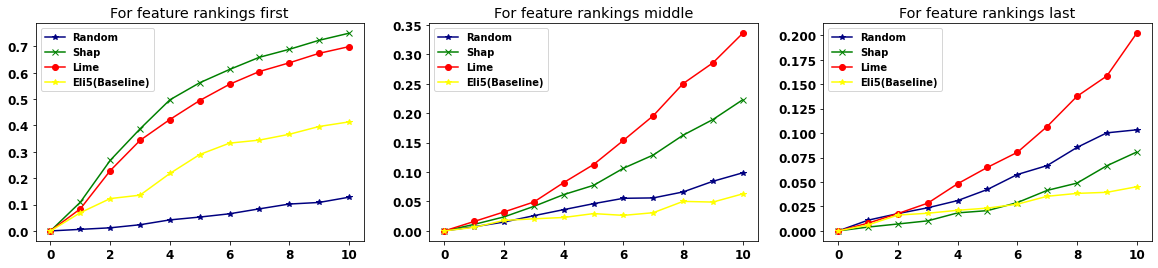

In [31]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))

def get_data(explainer, feature_rankings ):
    data = res[(res['nsamples'] == 'auto') &  (res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')]
    return data[data['explainer'] == explainer].groupby("no_features")["confidence_diff"].mean()

feature_rankings = "first"
no_of_features = list(range(0, len(get_data("random", "first")) ))
ax[0].plot( no_of_features,  get_data("random", feature_rankings), color='navy', marker='*', linestyle='-', label='Random')
ax[0].plot( no_of_features, get_data("shap", feature_rankings) , color='green', marker='x', linestyle='-', label='Shap')
ax[0].plot( no_of_features, get_data("lime", feature_rankings) , color='red', marker='o', linestyle='-', label='Lime')
ax[0].plot( no_of_features, get_data("eli5", feature_rankings) , color='yellow', marker='*', linestyle='-', label='Eli5(Baseline)')
ax[0].set_title("For feature rankings first")
ax[0].legend(loc='best')

feature_rankings = "middle"
no_of_features = list(range(0, len(get_data("random", feature_rankings)) ))
ax[1].plot( no_of_features, get_data("random", feature_rankings), color='navy', marker='*', linestyle='-', label='Random')
ax[1].plot( no_of_features, get_data("shap", feature_rankings), color='green', marker='x', linestyle='-', label='Shap')
ax[1].plot( no_of_features,get_data("lime", feature_rankings), color='red', marker='o', linestyle='-', label='Lime')
ax[1].plot( no_of_features, get_data("eli5", feature_rankings), color='yellow', marker='*', linestyle='-', label='Eli5(Baseline)')
ax[1].set_title("For feature rankings middle")
ax[1].legend(loc='best')

feature_rankings = "last"
no_of_features = list(range(0, len(get_data("random", feature_rankings)) ))
ax[2].plot( no_of_features, get_data("random", feature_rankings), color='navy', marker='*', linestyle='-', label='Random')
ax[2].plot( no_of_features, get_data("shap", feature_rankings), color='green', marker='x', linestyle='-', label='Shap')
ax[2].plot( no_of_features,get_data("lime", feature_rankings), color='red', marker='o', linestyle='-', label='Lime')
ax[2].plot( no_of_features, get_data("eli5", feature_rankings), color='yellow', marker='*', linestyle='-', label='Eli5(Baseline)')
ax[2].set_title("For feature rankings last")
ax[2].legend(loc='best')

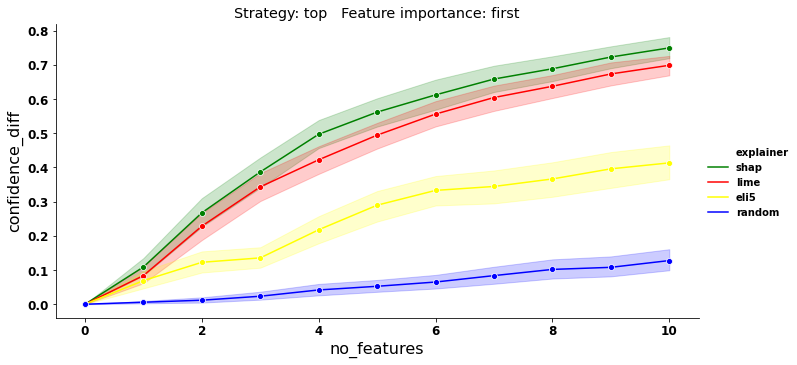

In [32]:
data = res[(res['nsamples'] == 'auto') & (res['strategy'] == 'distribution') &  (res["feature_rankings"] == "first")]
g = sns.relplot(x='no_features', y="confidence_diff", hue ='explainer', marker="o", kind="line", dashes=False, markers=True, data = data, height=5, aspect=2, palette = palette);
plt.title("Strategy: top   Feature importance: first")
# plt.legend(loc=2)
g.savefig(os.path.join(save_path, "avg_conf_change_distribution_first"))

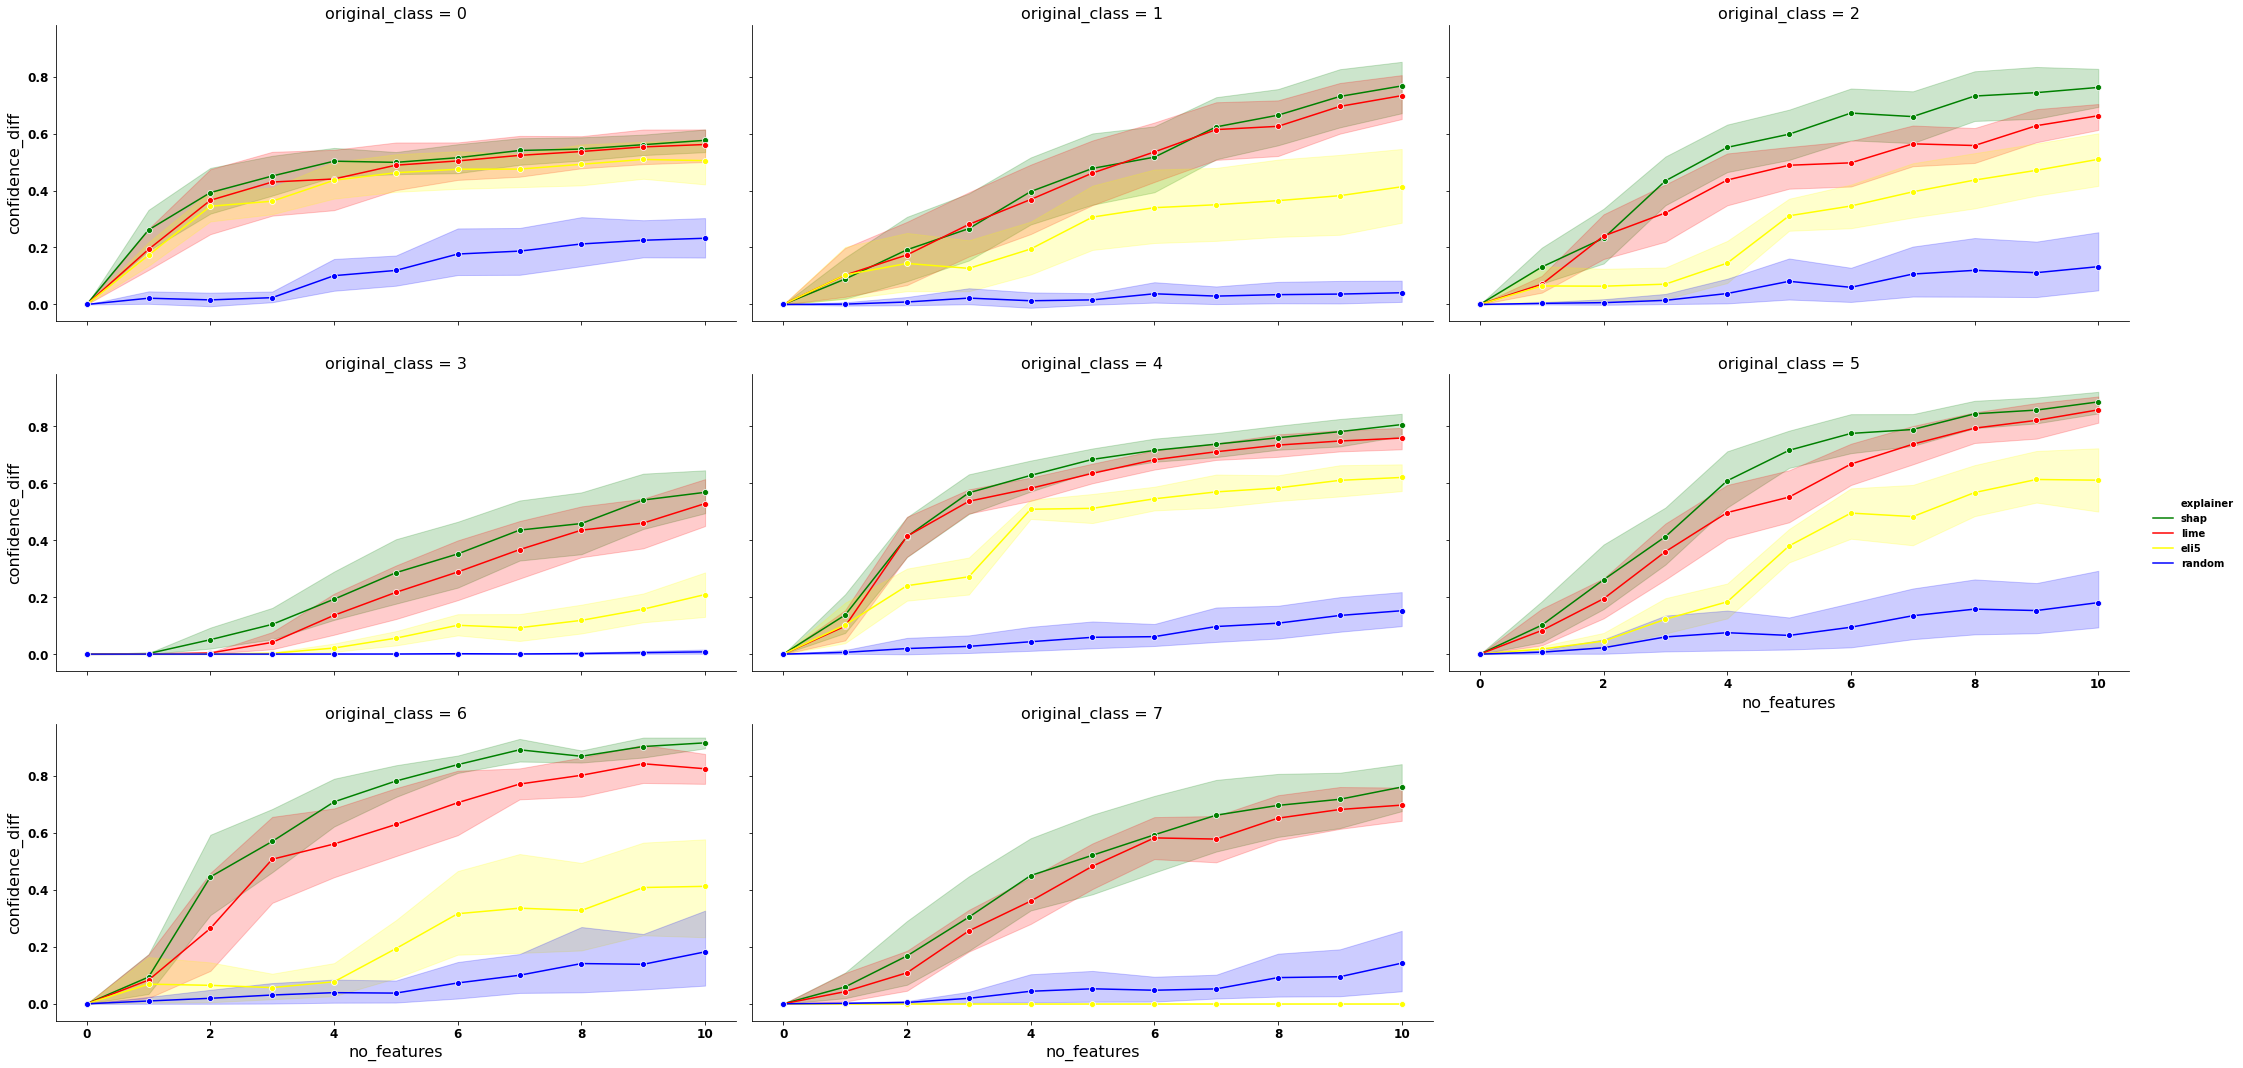

In [79]:
data = res[(res['nsamples'] == 'auto') & (res['strategy'] == 'distribution') &  (res["feature_rankings"] == "first")]
g = sns.relplot(x='no_features', y="confidence_diff", hue ='explainer',  col="original_class", col_wrap=3,  marker="o", kind="line", dashes=False, markers=True, data = data, height=5, aspect=2, palette = palette);
# plt.title("Strategy: top   Feature importance: first")
# plt.legend(loc=2)
g.savefig(os.path.join(save_path, "avg_conf_change_distribution_first_per_class"))

In [34]:
# help(sns.relplot)

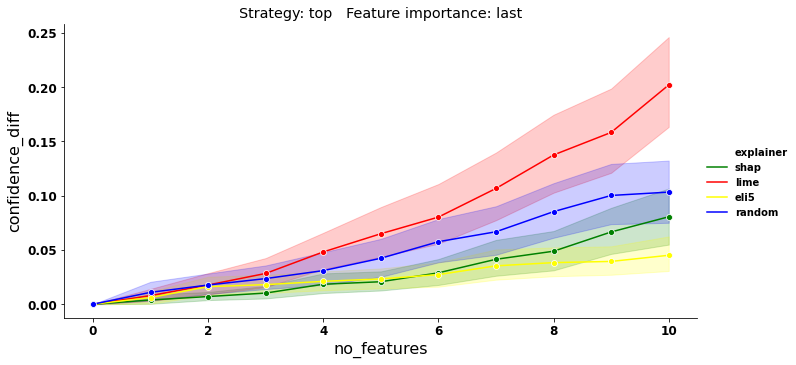

In [35]:
data = res[(res['nsamples'] == 'auto') & (res['strategy'] == 'distribution') &  (res["feature_rankings"] == "last")]
g = sns.relplot(x='no_features', y="confidence_diff", hue ='explainer', marker="o", kind="line", dashes=False, markers=True, data = data, height=5, aspect=2, palette = palette);
plt.title("Strategy: top   Feature importance: last")
g.savefig(os.path.join(save_path, "avg_conf_change_distribution_last"))

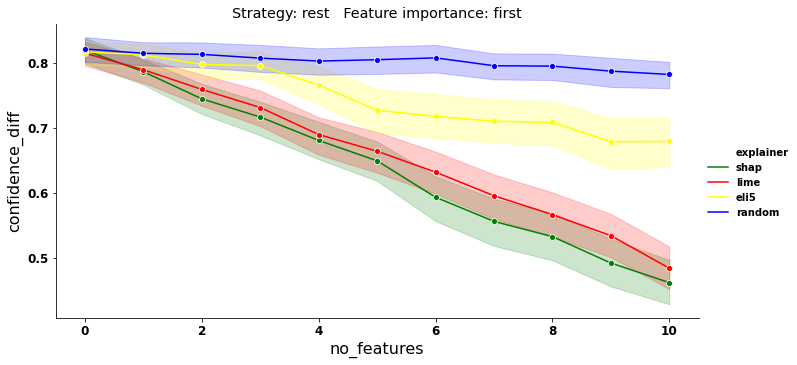

In [36]:
data = res[(res['nsamples'] == 'auto') & (res['strategy'] == 'distribution_others') &  (res["feature_rankings"] == "first")]
g = sns.relplot(x='no_features', y="confidence_diff", hue ='explainer', marker="o", kind="line", dashes=False, markers=True, data = data, height=5, aspect=2, palette = palette);
plt.title("Strategy: rest   Feature importance: first")
g.savefig(os.path.join(save_path, "avg_conf_change_distribution_others_first"))

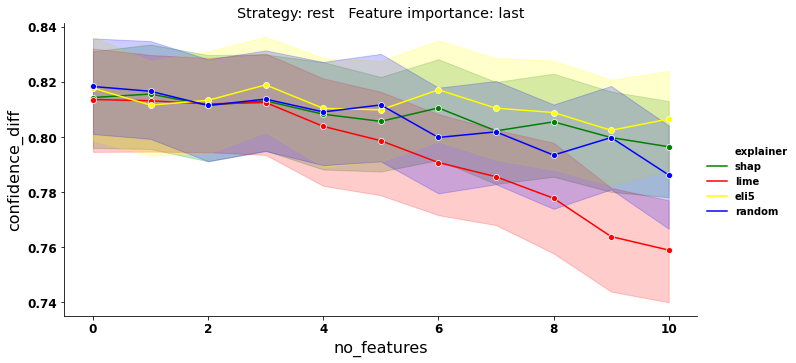

In [37]:
data = res[(res['nsamples'] == 'auto') & (res['strategy'] == 'distribution_others') &  (res["feature_rankings"] == "last")]
g = sns.relplot(x='no_features', y="confidence_diff", hue ='explainer', marker="o", kind="line", dashes=False, markers=True, data = data, height=5, aspect=2, palette = palette);
plt.title("Strategy: rest   Feature importance: last")
g.savefig(os.path.join(save_path, "avg_conf_change_distribution_others_last"))

In [38]:
res[(res['nsamples'] == 'auto') & (res['strategy'] == 'distribution')]

,original_probability,new_probability,confidence_diff,original_class,class_change,no_features,nsamples,explainer,time,feature_rankings,strategy,i0,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10
1,1.138276e-01,0.113828,-1.788139e-07,4,False,0,auto,shap,4.409572,first,distribution,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.138276e-01,0.113828,-1.788139e-07,4,False,0,auto,shap,6.394189,middle,distribution,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1.138276e-01,0.113828,-1.788139e-07,4,False,0,auto,shap,5.921405,last,distribution,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1.138276e-01,0.448032,3.842698e-01,4,False,1,auto,shap,5.464636,first,distribution,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,1.138276e-01,0.198094,9.140080e-02,4,False,1,auto,shap,5.597192,middle,distribution,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43150,9.276787e-07,0.000007,7.580697e-03,2,False,9,auto,random,2.003251,middle,distribution,8.0,35.0,37.0,28.0,57.0,46.0,3.0,25.0,44.0,NaN,NaN
43153,9.276787e-07,0.000040,4.045248e-03,2,False,9,auto,random,2.042847,last,distribution,58.0,9.0,24.0,52.0,15.0,12.0,20.0,66.0,69.0,NaN,NaN
43156,9.276787e-07,0.000008,9.273887e-04,2,False,10,auto,random,1.872403,first,distribution,11.0,10.0,51.0,2.0,30.0,39.0,61.0,31.0,60.0,22.0,NaN
43159,9.276787e-07,0.000007,3.832877e-03,2,False,10,auto,random,1.854744,middle,distribution,67.0,8.0,35.0,37.0,28.0,57.0,46.0,3.0,25.0,44.0,NaN


In [39]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
def t_test(data1, data2):
    # seed the random number generator
    seed(1)
    # generate two independent samples
#     data1 = 5 * randn(100) + 50
#     data2 = 5 * randn(100) + 51
    # compare samples
    stat, p = mannwhitneyu(data1, data2)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')

def calculate_p(explainer1, explainer2, strategy, original_class, feature_number, feature_rankings = "first", nsamples = 'auto'):
    data1 = res[ (res['strategy'] == strategy) & (res['explainer'] == explainer1) & (res['no_features'] == feature_number) & 
#                 (res['original_class'] == original_class) &
                (res["feature_rankings"] == feature_rankings) & (res['nsamples'] == nsamples)]["confidence_diff"]
    data2 = res[ (res['strategy'] == strategy) & (res['explainer'] == explainer2) & (res['no_features'] == feature_number) & 
#                 (res['original_class'] == original_class) &
                 (res["feature_rankings"] == feature_rankings) & (res['nsamples'] == nsamples)]["confidence_diff"]
    print("Data1 mean {} Data2 mean {}".format(data1.mean(), data2.mean()))
    t_test(data1, data2)
    
calculate_p("lime", "shap", "distribution", original_class= 4, feature_number=4)

Data1 mean 0.4226029790192661 Data2 mean 0.49724447081651374
Statistics=4791.000, p=0.007
Different distribution (reject H0)


## G8 Average of confidence level change vs number of features neutralized. If no feature is altered the (old prediction - new prediction) == 0 should stay the same. The more features we change, the higher should the difference increase. This average is per class

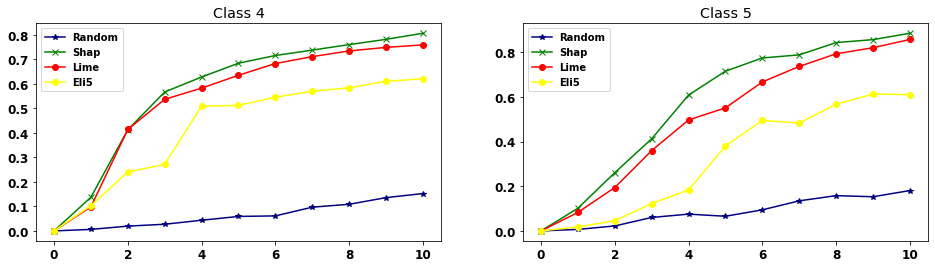

<Figure size 792x288 with 0 Axes>

<Figure size 792x288 with 0 Axes>

In [40]:
# Same as the graph above but the plot is class specific, in this case for class 1. For class 0, there are not enough datapoints to plot the graph
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

def get_data(explainer, original_class):
    default_data = res[(res['nsamples'] == 'auto') & (res["feature_rankings"] == "first") & (res['strategy'] == 'distribution')]
    return default_data[(default_data['explainer'] == explainer) & (default_data['original_class'] == original_class)].groupby("no_features")["confidence_diff"].mean()

original_class = 4
plt.figure(figsize=(11,4))
no_of_features = list(range(0, len(get_data("random", original_class)) ))
ax[0].plot( no_of_features, get_data("random", original_class), color='navy', marker='*', linestyle='-', label='Random')
ax[0].plot( no_of_features, get_data("shap", original_class), color='green', marker='x', linestyle='-', label='Shap')
ax[0].plot( no_of_features, get_data("lime", original_class), color='red', marker='o', linestyle='-', label='Lime')
ax[0].plot( no_of_features, get_data("eli5", original_class), color='yellow', marker='o', linestyle='-', label='Eli5')
ax[0].set_title("Class {}".format(original_class))
ax[0].legend(loc='best')

original_class = 5
plt.figure(figsize=(11,4))
no_of_features = list(range(0, len(get_data("random", original_class)) ))
ax[1].plot( no_of_features, get_data("random", original_class), color='navy', marker='*', linestyle='-', label='Random')
ax[1].plot( no_of_features, get_data("shap", original_class), color='green', marker='x', linestyle='-', label='Shap')
ax[1].plot( no_of_features, get_data("lime", original_class), color='red', marker='o', linestyle='-', label='Lime')
ax[1].plot( no_of_features, get_data("eli5", original_class), color='yellow', marker='o', linestyle='-', label='Eli5')
ax[1].set_title("Class {}".format(original_class))
ax[1].legend(loc='best')

## G9 Percentage of rows where the new prediction favours the original class instead of decreasing its probability or has no impact. (old prediction - new prediction) <=0.1. Interesting to change ((res["original_class"] == 0/1))

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


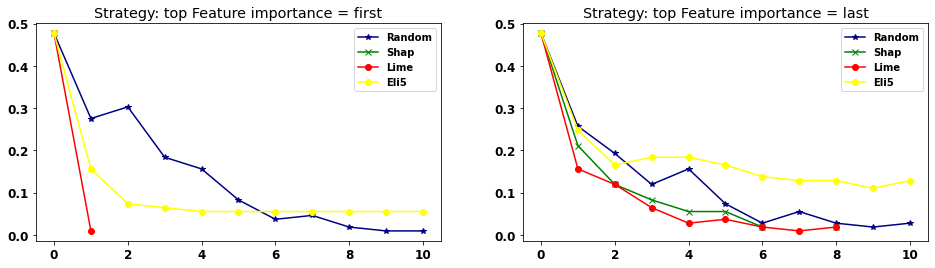

In [41]:
def get_data(explainer, feature_rankings):
    data = res[(res['nsamples'] == 'auto') & (res["feature_rankings"] == feature_rankings) 
#                & (res["original_class"] == 1)
               & (res['strategy'] == 'distribution')] 
    data_count = data[(res['confidence_diff'] < 0.0)]
    return data_count[data_count['explainer'] == explainer].groupby("no_features")["confidence_diff"].count() / data[data['explainer'] == explainer].groupby("no_features")["confidence_diff"].count()

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

feature_rankings = "first"
no_of_features = list(range(0, len(get_data("random", feature_rankings)) ))
ax[0].plot( no_of_features, get_data("random", feature_rankings), color='navy', marker='*', linestyle='-', label='Random')
ax[0].plot( no_of_features, get_data("shap", feature_rankings), color='green', marker='x', linestyle='-', label='Shap')
ax[0].plot( no_of_features, get_data("lime", feature_rankings), color='red', marker='o', linestyle='-', label='Lime')
ax[0].plot( no_of_features, get_data("eli5", feature_rankings), color='yellow', marker='o', linestyle='-', label='Eli5')
ax[0].set_title("Strategy: top Feature importance = first")
ax[0].legend(loc='best')

feature_rankings = "last"
no_of_features = list(range(0, len(get_data("random", feature_rankings)) ))
ax[1].plot( no_of_features, get_data("random", feature_rankings), color='navy', marker='*', linestyle='-', label='Random')
ax[1].plot( no_of_features, get_data("shap", feature_rankings), color='green', marker='x', linestyle='-', label='Shap')
ax[1].plot( no_of_features, get_data("lime", feature_rankings), color='red', marker='o', linestyle='-', label='Lime')
ax[1].plot( no_of_features, get_data("eli5", feature_rankings), color='yellow', marker='o', linestyle='-', label='Eli5')
ax[1].set_title("Strategy: top Feature importance = last")
ax[1].legend(loc='best')
# label='Lime Confidence level change vs no of features'
f.savefig(os.path.join(save_path, "conf_level_change_reverse_top_first_last"))

## G10 Average time for shap and lime to compute feature importances using nsamples auto (default). Shap is significantly higher. 

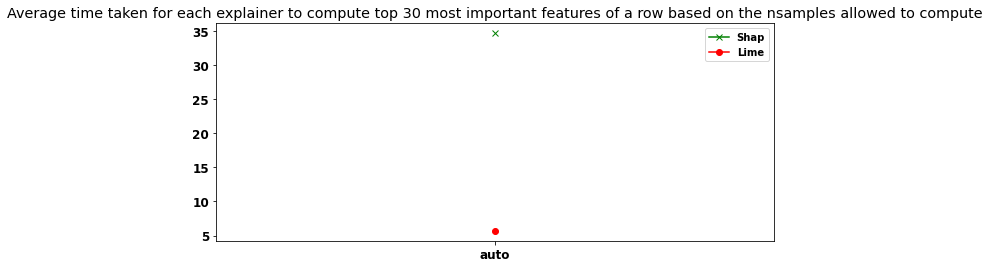

In [42]:
avg_shap = res[(res["no_features"]==0) & (res['explainer'] == 'shap')  & (res["feature_rankings"] == "first") & (res['strategy'] == 'mean')].groupby("nsamples")["time"].mean()
avg_lime = res[(res["no_features"]==0) & (res['explainer'] == 'lime')  & (res["feature_rankings"] == "first") & (res['strategy'] == 'mean')].groupby("nsamples")["time"].mean()

plt.figure(figsize=(10,4))
# plt.set_title('Training & Validation Loss')
no_of_features = list(range(0, len(avg_shap)))
# plt.plot( no_of_features, avg_random, color='navy', marker='*', linestyle='-', label='Random')
plt.plot( avg_lime.keys(), avg_shap, color='green', marker='x', linestyle='-', label='Shap')
plt.plot( avg_lime.keys(), avg_lime, color='red', marker='o', linestyle='-', label='Lime')
plt.title("Average time taken for each explainer to compute top 30 most important features of a row based on the nsamples allowed to compute")
plt.legend(loc='best')

# Some graphs generated by explainers

## G11 Eli5 This computes the global feature importance - this is not a true eli5 algorithm.

In [43]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

def base_model():       
    return  tf.keras.models.load_model('{}/{}.h5'.format(name, name), custom_objects={"f1": kr.f1, "optimizer": ranger})
# X_train_unscaled, X_test_unscaled, y_train, y_test
# train_x, val_x, train_y, val_y
my_model = KerasClassifier(build_fn=base_model)    
my_model.fit(X_test, y_test)

perm = PermutationImportance(my_model).fit(X_test,y_test)
eli5.show_weights(perm, feature_names = list(df.drop('class', axis=1).columns))

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


4/4 [==============================] - 0s 3ms/step - loss: 0.1469 - accuracy: 0.9640


4/4 [==============================] - 0s 5ms/step - loss: 0.2213 - accuracy: 0.9009


Weight,Feature
0.0739 ± 0.0310,pCAMKII_N
0.0631 ± 0.0279,CaNA_N
0.0505 ± 0.0371,pERK_N
0.0468 ± 0.0239,S6_N
0.0414 ± 0.0216,APP_N
0.0342 ± 0.0210,BRAF_N
0.0270 ± 0.0255,ITSN1_N
0.0270 ± 0.0114,pGSK3B_N
0.0270 ± 0.0161,pGSK3B_Tyr216_N
0.0216 ± 0.0244,JNK_N


In [44]:
help(PermutationImportance)

Help on class PermutationImportance in module eli5.sklearn.permutation_importance:

class PermutationImportance(sklearn.base.BaseEstimator, sklearn.base.MetaEstimatorMixin)
 |  PermutationImportance(estimator, scoring=None, n_iter=5, random_state=None, cv='prefit', refit=True)
 |  
 |  Meta-estimator which computes ``feature_importances_`` attribute
 |  based on permutation importance (also known as mean score decrease).
 |  
 |  :class:`~PermutationImportance` instance can be used instead of
 |  its wrapped estimator, as it exposes all estimator's common methods like
 |  ``predict``.
 |  
 |  There are 3 main modes of operation:
 |  
 |  1. cv="prefit" (pre-fit estimator is passed). You can call
 |     PermutationImportance.fit either with training data, or
 |     with a held-out dataset (in the latter case ``feature_importances_``
 |     would be importances of features for generalization). After the fitting
 |     ``feature_importances_`` attribute becomes available, but the estimat

## G12 Lime example

In [77]:
row_number=42
columns = list(df.drop('class', axis=1).columns)
explainer_lime = lime_tabular.LimeTabularExplainer(X_train, feature_names= columns)
exp = explainer_lime.explain_instance(X_test[row_number], model.predict, num_features=30, top_labels=30)  
exp.show_in_notebook(show_table=False, show_all=False)
# model.predict()

In [46]:
help(exp.show_in_notebook)

Help on method show_in_notebook in module lime.explanation:

show_in_notebook(labels=None, predict_proba=True, show_predicted_value=True, **kwargs) method of lime.explanation.Explanation instance
    Shows html explanation in ipython notebook.
    
    See as_html() for parameters.
    This will throw an error if you don't have IPython installed



## G13 Shap example decision plot

In [47]:
# eli5.show_prediction(model, X_test[row_number].reshape(1, X_test.shape[1]))

In [74]:
# https://slundberg.github.io/shap/notebooks/plots/decision_plot.html -- types of plots available for shap
import shap
row_number=42
explainer_shap = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer_shap.shap_values(X_test[row_number].reshape(1, X_test.shape[1]), nsamples="auto", l1_reg="num_features(30)")

correct_class = model.predict_classes(X_test[row_number].reshape(1, X_test.shape[1]))[0]
shap.initjs()
shap.force_plot(explainer_shap.expected_value[correct_class], shap_values[correct_class], X_test[row_number], feature_names=list(df.drop('class', axis=1).columns), link="identity")

# shap.decision_plot(explainer_shap.expected_value[correct_class], shap_values[correct_class][0, :], X_test[row_number], feature_names=list(df.drop('class', axis=1).columns), link="identity")

## G14 Shap example force plot (same as a decision plot)

In [68]:
shap.initjs()
shap.force_plot(explainer_shap.expected_value[correct_class], shap_values[correct_class], X_test[row_number], feature_names=list(df.drop('class', axis=1).columns), link="identity")
# save("shap_example")
# plt.savefig(os.path.join(save_path, "shap_example"))

In [60]:
explainer_shap.expected_value

array([0.05605486, 0.136918  , 0.10706702, 0.13982141, 0.16524495,
       0.13842749, 0.11427501, 0.14219125])

In [76]:
model.predict(X_test[row_number].reshape(1, X_test.shape[1]))

array([[1.8140091e-01, 1.5700854e-02, 5.5475038e-04, 5.1687970e-03,
        7.7890575e-01, 1.0838091e-02, 9.1956375e-04, 6.5112603e-03]],
      dtype=float32)

In [52]:
help(shap.force_plot)

Help on function force_plot in module shap.plots.force:

force_plot(base_value, shap_values, features=None, feature_names=None, out_names=None, link='identity', plot_cmap='RdBu', matplotlib=False, show=True, figsize=(20, 3), ordering_keys=None, ordering_keys_time_format=None, text_rotation=0)
    Visualize the given SHAP values with an additive force layout.
    
    Parameters
    ----------
    base_value : float
        This is the reference value that the feature contributions start from. For SHAP values it should
        be the value of explainer.expected_value.
    
    shap_values : numpy.array
        Matrix of SHAP values (# features) or (# samples x # features). If this is a 1D array then a single
        force plot will be drawn, if it is a 2D array then a stacked force plot will be drawn.
    
    features : numpy.array
        Matrix of feature values (# features) or (# samples x # features). This provides the values of all the
        features, and should be the same shap

In [53]:
class_avg_1 = [a for a in y_test if a  ==1]
sum(class_avg_1)/len(y_train)
# class_avg_1
model.predict(X_test[row_number].reshape(1, X_test.shape[1]))

array([[4.0751984e-03, 4.5640685e-04, 1.9487021e-05, 9.1345684e-04,
        9.8852438e-01, 5.9841555e-03, 1.5860691e-05, 1.1095526e-05]],
      dtype=float32)

## G15 Shap summary plot ( a global feature importance plot - only 10 values are used as it would not complete otherwise)

In [54]:

# shap.summary_plot(global_shap_values, X_test)

In [55]:
help(shap.summary_plot)

Help on function summary_plot in module shap.plots.summary:

summary_plot(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', auto_size_plot=None)
    Create a SHAP summary plot, colored by feature values when they are provided.
    
    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.
    
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand
    
    feature_names : list
        Names of the features (length # features)
    
    max_display : int
        How many top

In [56]:
global_shap_values = explainer_shap.shap_values(X_test)
shap.summary_plot(global_shap_values, X_test, plot_type="bar", feature_names=list(df.drop('class', axis=1).columns))

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_


Traceback (most recent call last):
  File "c:\users\dan39\onedrive\desktop\dissertation\python3.8\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-56-8a217b674654>", line 1, in <module>
    global_shap_values = explainer_shap.shap_values(X_test)
  File "c:\users\dan39\onedrive\desktop\dissertation\python3.8\lib\site-packages\shap\explainers\kernel.py", line 211, in shap_values
    explanations.append(self.explain(data, **kwargs))
  File "c:\users\dan39\onedrive\desktop\dissertation\python3.8\lib\site-packages\shap\explainers\kernel.py", line 401, in explain
    self.run()
  File "c:\users\dan39\onedrive\desktop\dissertation\python3.8\lib\site-packages\shap\explainers\kernel.py", line 532, in run
    modelOut = self.model.f(data)
  File "c:\users\dan39\onedrive\desktop\dissertation\python3.8\lib\site-packages\tensorflow\python\keras\engine\training.py", line 88, in _method_wrapper
  

TypeError: object of type 'NoneType' has no len()

## G16 Tensorboard results - ordereded by ray/tune/keras_info/val_binary_accuracy

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir "tune_results/" 

In [ ]:
stop
import os
path="/home/dan393/ray_results_f/create_model_tune_cofig"
os.chdir(path)
for file in os.listdir():
    if os.path.isdir(file):
        split_words = file.split("_")
        os.rename(file, "create_model_tune_cofig_{}_{}".format(split_words[4], split_words[len(split_words)-1]))

In [ ]:
import os
path="/home/dan393/ray_results_f/create_model_tune_cofig"
os.chdir(path)
for file in os.listdir():
    if os.path.isdir(file):
        split_words = file.split("_")
        os.rename(file, "create_model_tune_cofig_{}_{}".format(split_words[4], split_words[len(split_words)-1]))